In [3199]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii, votable
from astropy.table import Table, vstack, hstack
import os, sys
from astropy.io import fits
from scipy.interpolate import interp2d, interp1d
from scipy.interpolate import griddata
import importlib
import WD_models
import WD_HR

## Import Evolution Tracks

In [4626]:
importlib.reload(WD_models)
importlib.reload(WD_HR)

/Users/scheng/Gaia/WD_models.py:120: RuntimeWarning: invalid value encountered in less
  selected = ~np.isnan(bp_rp_fontaine+G_fontaine+age+para)*(G_fontaine<16)*(G_fontaine>8)
/Users/scheng/Gaia/WD_models.py:120: RuntimeWarning: invalid value encountered in greater
  selected = ~np.isnan(bp_rp_fontaine+G_fontaine+age+para)*(G_fontaine<16)*(G_fontaine>8)
/Users/scheng/Gaia/WD_models.py:14: RuntimeWarning: invalid value encountered in greater
  return (mass_ini>1.5)*mass_ini**(-2.3)
/Users/scheng/Gaia/WD_models.py:345: RuntimeWarning: divide by zero encountered in log10
  grid_logage_for_density, grid_logage_for_density_func = HR_to_para(np.log10(age_for_density),\


<module 'WD_HR' from '/Users/scheng/Gaia/WD_HR.py'>

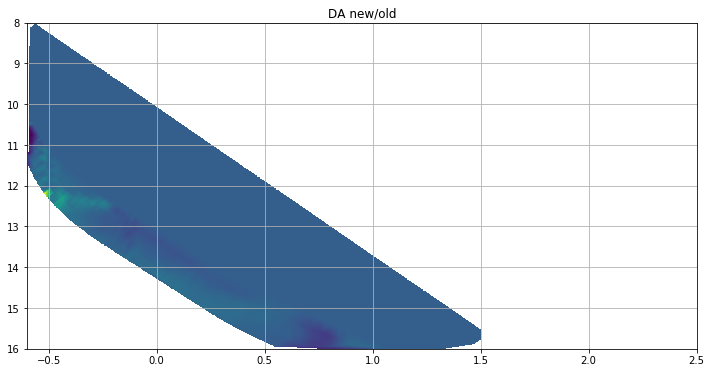

In [4080]:
plt.figure(figsize=(12,6))
xy = WD_models.xy
plt.imshow((WD_models.DA_thick_ONe['grid_density']/WD_models.DA_thick_CO['grid_density']).T,\
           extent=(xy[0],xy[1],xy[3],xy[4]),aspect='auto',origin='lower')
plt.ylim(16,8)
plt.xlim(-0.6,2.5)
plt.title('DA new/old')
plt.grid()
plt.show()

/Users/scheng/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)


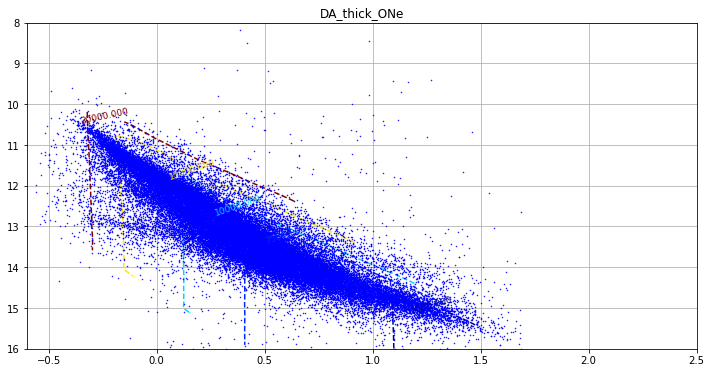

In [2589]:
spec_type = 'DA_thick'
model = 'ONe'
plt.figure(figsize=(12,6))
WD_models.plot_contours(eval('WD_models.'+spec_type+'_'+model)['grid_teff'],\
                        [5000,7500,10000,15000,20000],[5000,7500,10000,15000,20000],0)
plt.title(spec_type+'_'+model)
plt.show()

/Users/scheng/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)
/Users/scheng/Gaia/WD_models.py:277: RuntimeWarning: invalid value encountered in greater
  selected = grid_para>0


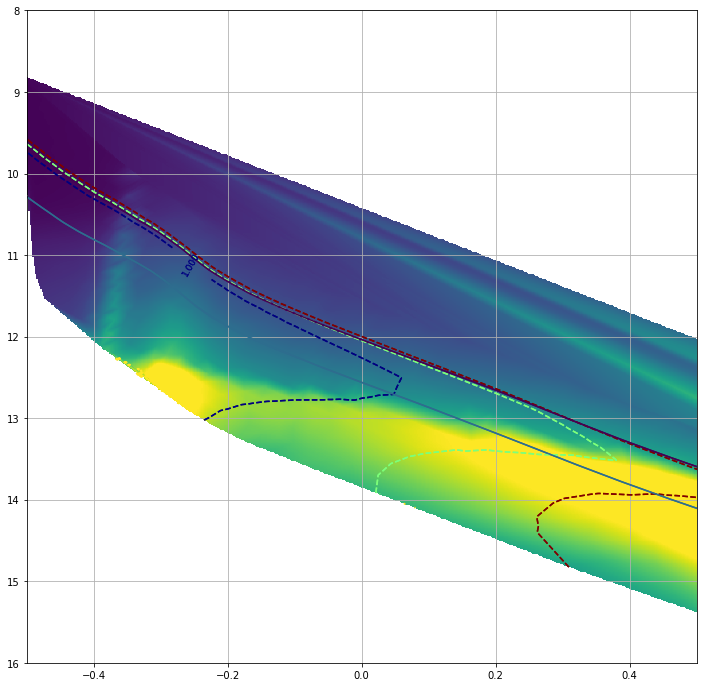

In [4460]:
spec_type = 'DB'
model = 'CO'
WD_model = eval('WD_models.'+spec_type+'_'+model)

plt.figure(figsize=(12,12))
WD_models.final_plot(eval('WD_models.'+spec_type+'_'+model)['grid_density'],\
                     eval('WD_models.'+spec_type+'_'+model)['grid_logage'],\
                     eval('WD_models.'+spec_type+'_'+model)['grid_mass'],0,0,stars='off',\
                    age_levels=[1,2,3],age_labels=[1],\
               mass_levels=[0.58,0.8,1.2],mass_labels=[0.8])
plt.xlim(-0.5,0.5)
plt.show()

## Inspect One Evolutionary Track

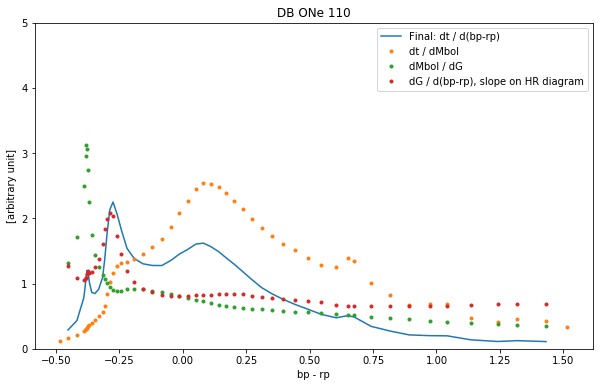

In [4461]:
spec_type = 'DB'
model = 'ONe'
plt.figure(figsize=(10,6))
mass_array, logg, age, age_for_density, logteff, Mbol, G_track, bp_rp_track,\
t_bprp, t_Mbol, t_G, G_bprp, Mbol_G, Mbol_logteff =\
    WD_models.inspect_a_track(spec_type,model,'110',pl_type='bprp')
plt.ylim(0,5)
plt.show()

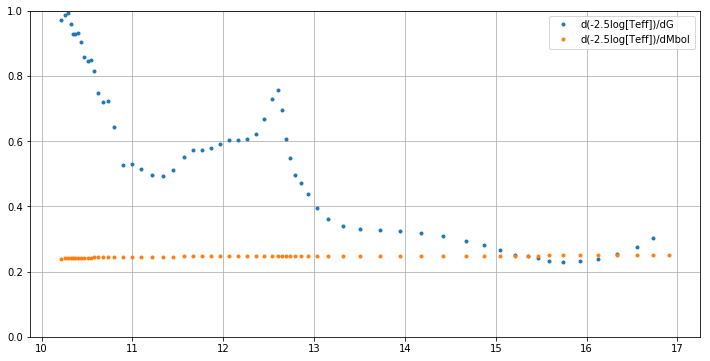

In [2525]:
plt.figure(figsize=(12,6))
plt.plot(G_track[1:-1],WD_models.slope(-2.5*logteff, G_track),'.',label='d(-2.5log[Teff])/dG')
plt.plot(G_track[1:-1],WD_models.slope(-2.5*logteff, Mbol),'.',label='d(-2.5log[Teff])/dMbol')
plt.legend()
plt.ylim(0,1)
plt.grid()
plt.title(spec_type+' '+model+' '+mass)
plt.show()

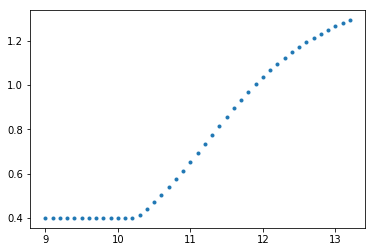

In [4087]:
WD_model = WD_models.DA_thick_CO
mass_func = np.vectorize(lambda x:WD_model['grid_mass_func'](-0.3,x))
plt.plot(np.arange(8,16,0.1),mass_func(np.arange(8,16,0.1)),'.')
plt.show()

(1050, 800)


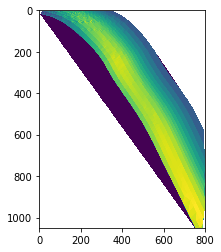

In [4088]:
plt.imshow(WD_model['grid_mass_density'])
print(WD_model['grid_mass_density'].shape)
plt.show()

## Open WD tables

In [4538]:
WD_warwick = Table.read('gaia_dr2_wd_candidates_v1.0.csv')
WD_warwick['bp_rp'] = WD_warwick['phot_bp_mean_mag']-WD_warwick['phot_rp_mean_mag']
WD_warwick['G'] = WD_warwick['phot_g_mean_mag']+5*np.log10(WD_warwick['parallax']/1000)+5

In [4539]:
WD_direct = np.load('WD_planet.npy')[0]['WD_planet']
WD_direct['G'] = WD_direct['phot_g_mean_mag']+5*np.log10(WD_direct['parallax']/1000)+5

In [4540]:
WD_sdss = np.load('WD_table_sdss_local.npy')[0]['table']
WD_sdss = WD_sdss[WD_sdss['MWDD_d']<10]

## get velocity, select,  add age and mass

In [4556]:
def select_WD(WD_table, bprp_excess=1.3, bprp_error=0.05, ev=2, G=19.5, d_ed=10):
    selected = (WD_table['phot_bp_rp_excess_factor']<bprp_excess)*\
        (WD_table['parallax']/WD_table['parallax_error']>d_ed)*\
        ((np.sqrt((WD_table['phot_bp_mean_flux_error']/WD_table['phot_bp_mean_flux'])**2+\
        (WD_table['phot_bp_mean_flux_error']/WD_table['phot_bp_mean_flux'])**2)\
                  <bprp_error ))*\
           (WD_table['phot_g_mean_mag']<G) * (WD_table['ev']<ev)
    print(selected.sum())
    return selected

def para_of_WD(WD_table):
    WD_model = eval('WD_models.'+spec_type+'_'+model)
    age_planet = 10**WD_model['grid_logage_func'](WD_table['bp_rp']-0.03,WD_table['G'])/10**9
    mass_planet = WD_model['grid_mass_func'](WD_table['bp_rp']-0.03,WD_table['G'])
    return age_planet, mass_planet

In [4557]:
importlib.reload(WD_HR)
WD_warwick['v'], WD_warwick['ev'], WD_warwick['U'], WD_warwick['V'], WD_warwick['W']=\
        WD_HR.get_v_and_ev(WD_warwick)
WD_sdss['v'], WD_sdss['ev'], WD_sdss['U'], WD_sdss['V'], WD_sdss['W'] = WD_HR.get_v_and_ev(WD_sdss)

selected = select_WD(WD_warwick,1.5,0.15,1,22,8)
selected_MWDD = select_WD(WD_sdss,1.5,0.15,1,22,8)
WD = WD_warwick[selected].copy()

for spec_type, model in \
    [['DA_thick','CO'],['DA_thick','ONe'],['DB','CO'],['DB','ONe']]:
    age_planet, mass_planet = para_of_WD(WD_sdss) 
    WD_sdss['age_'+spec_type+'_'+model] = age_planet
    WD_sdss['mass_'+spec_type+'_'+model] = mass_planet

for spec_type, model in \
    [['DA_thick','CO'],['DA_thick','ONe'],['DB','CO'],['DB','ONe']]:
    age_planet, mass_planet = para_of_WD(WD) 
    WD['age_'+spec_type+'_'+model] = age_planet
    WD['mass_'+spec_type+'_'+model] = mass_planet

10715
1505


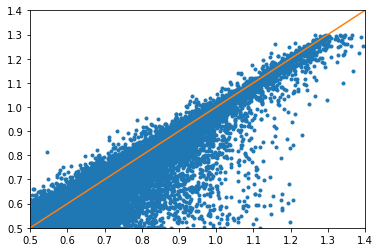

In [3779]:
plt.plot(WD['mass'],WD['mass_DA_thick_CO'],'.')
plt.plot([0.5,1.4],[0.5,1.4])
plt.xlim(0.5,1.4); plt.ylim(0.5,1.4)
plt.show()

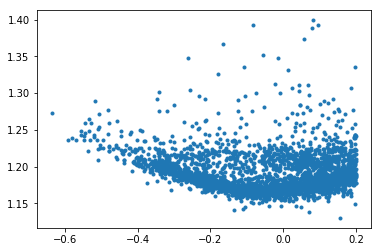

In [4744]:
x = WD['parallax'] / WD['parallax_error']
y = 1/WD['parallax']*1000
z = WD['phot_g_mean_mag']
z = WD['phot_g_mean_mag']+5*np.log10(WD['parallax']/1000)+5
#selected2 = np.log10(y)-(np.log10(x)-1)*(-0.5)<2
x = WD_direct['bp_rp']
y = WD_direct['phot_bp_rp_excess_factor']
plt.plot(x,y,'.')
#plt.plot(x[selected2],y[selected2],'.',ms=1)
#plt.xscale('log')
#plt.yscale('log')
plt.show()

## completeness

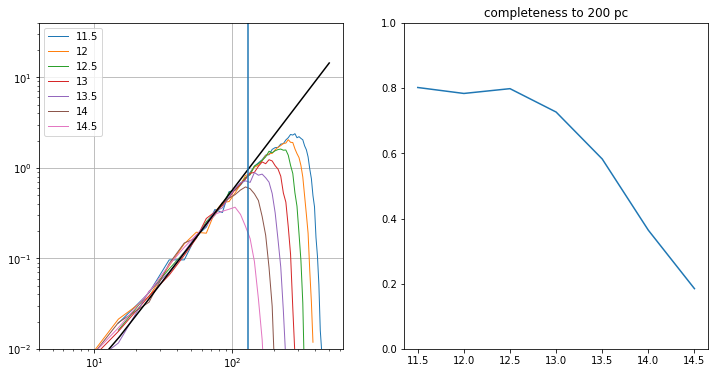

In [4742]:
#correction = [10**2.15,10**1.25,10**0.55,10**0.25,1,1]
G = [11.5,12,12.5,13,13.5,14,14.5]
GM = WD['phot_g_mean_mag']+5*np.log10(WD['parallax']/1000)+5
completeness = np.zeros(len(G))

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
dm = 0; dM = 500; N = 50
for i in range(len(G)):
    selected2 = np.abs(GM-G[i])<0.25
    count, bins = np.histogram(1/WD['parallax'][selected2]*1000,range=(dm,dM),bins=N)
    correction = count[:8].sum()
    plt.plot((bins[1:]+bins[:-1])/2,count/correction,'-',lw=1,label=str(G[i]))
    completeness[i] = count[:20].sum() / (correction*(20/8)**3)
x = np.linspace(dm,dM,N)
y = (x+(dM-dm)/N)**3 - x**3
plt.plot(x+(dM-dm)/N/2,y/(y[:8].sum()),'k')
plt.xscale('log')
plt.yscale('log')
plt.axvline(130)
plt.ylim(0.01,40)
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(G,completeness)
plt.title('completeness to 200 pc')
plt.ylim(0,1)
plt.show()

In [3816]:
completeness_func = interp1d(G,completeness,fill_value=(completeness[0],completeness[-1]),\
                             bounds_error=False)

In [4929]:
importlib.reload(WD_HR)
def plot_vel_sample(WD,WD_model,v,vel,dvel,pl_type,distance,pl_model_hess=False,x_shift=0):
    plt.figure(figsize=(12,6))
    x = WD['bp_rp']-0.03
    y = WD['phot_g_mean_mag']+5*np.log10(WD['parallax']/1000)+5
    #z = WD['parallax']/WD['parallax_error']
    #z = WD['phot_bp_rp_excess_factor']
    #z = WD['phot_bp_rp_excess_factor']
    z = WD[v]
    selected2 = (1/WD['parallax']*1000<distance) * (np.abs(z-vel)<dvel)
    
    xm = -0.6; xM = 2.5
    ym = 16; yM = 8
    res = 50
    if pl_model_hess==True:
        WD_models.final_plot(WD_model['grid_density']*WD_model['grid_MF'],\
                             WD_model['grid_logage'],\
                             WD_model['grid_mass'],\
                             0,0,75,'off',100,\
                  age_levels=np.arange(1,10,1),age_labels=[])
    if pl_type=='hess':
        H, X_display, Y_display = hess(x[selected2]+x_shift, y[selected2], xm,xM,res*2,ym,yM,res,False)
        H = H/completeness_func(Y_display[1:,1:])
        plt.pcolormesh(X_display, Y_display, np.log10(H))
    if pl_type=='scatter':
        plt.scatter(x[selected2]+x_shift,y[selected2]-0,c=z[selected2],\
                    vmin=0,vmax=100,s=1,alpha=1)
        H, X_display, Y_display = None, None, None
    if pl_type=='hess_median':
        H, X_display, Y_display = hess_median(x[selected2]+x_shift, y[selected2], z[selected2],\
                               xm,xM,res*2,ym,yM,res)
        plt.colorbar()
        WD_models.plot_contours(\
            WD_model['grid_mass'],[0.58],[],0,stars='off',linestyle='dotted')
        WD_models.plot_contours(\
            10**WD_model['grid_logage']/10**9,[1.5],[],0,stars='off',linestyle='dotted')
    plt.xlim(-0.6,2.5)
    plt.ylim(16,8)
    plt.grid('off')
    plt.title(spec_type+' '+model)
    return H, X_display, Y_display

/Users/scheng/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)


3414


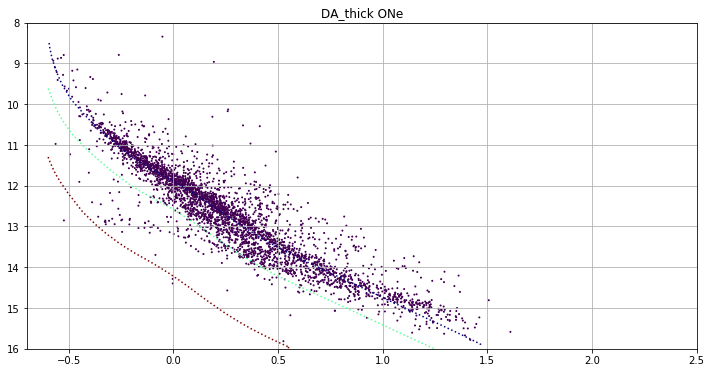

3766


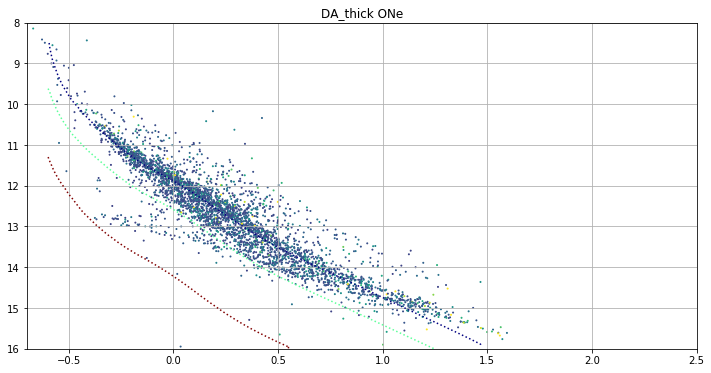

23278


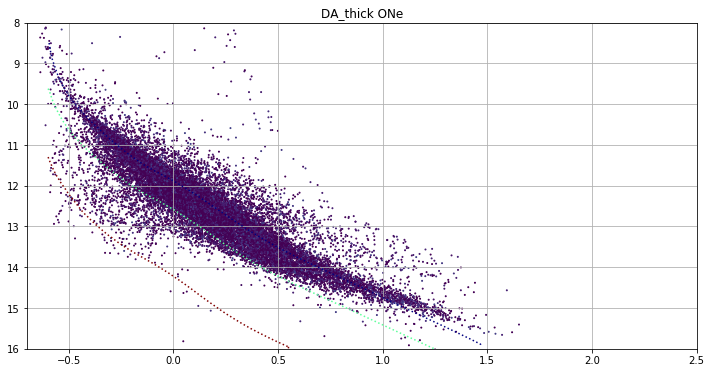

5942


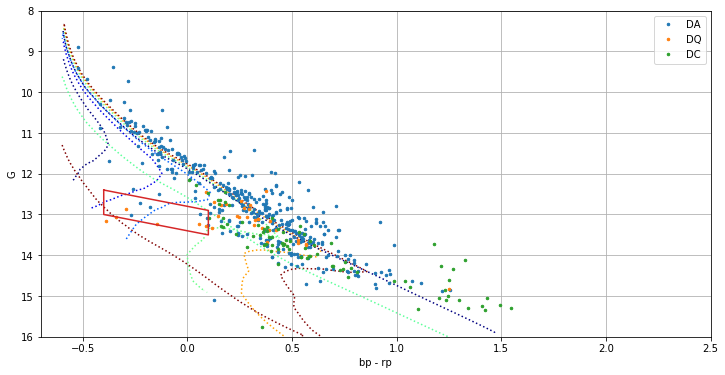

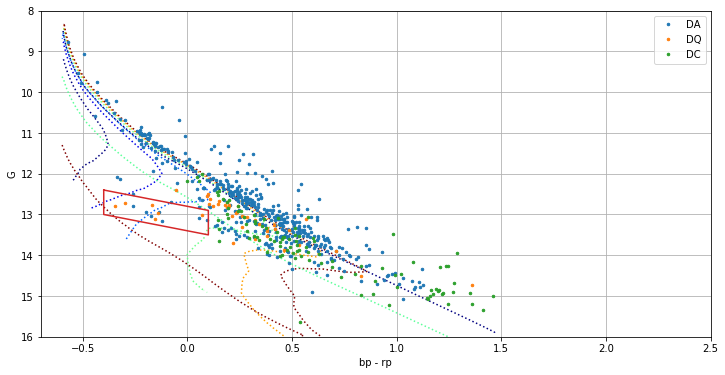

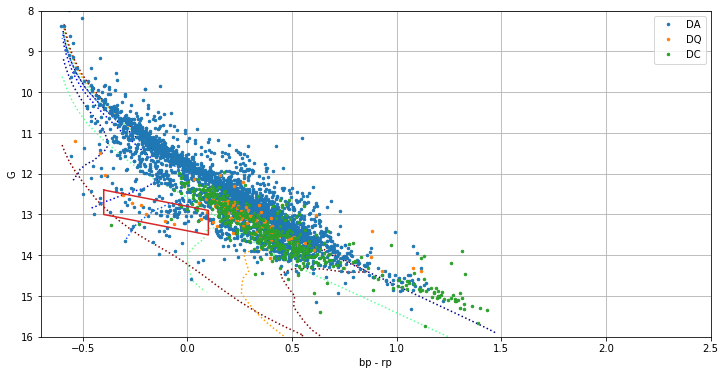

In [4941]:
spec_type = 'DA_thick'
model = 'ONe'
x_shift = 0
distance = 200
WD_model = eval('WD_models.'+spec_type+'_'+model)
v = 'W'

dvel = [25,25,50,50]
vel = [25,75,150,250]

dvel = [9,22,30,100,200]
vel = [9,20,72,200,200]

dvel = [100,100,20]
vel = [-120,120,0]
for i in range(len(vel)):
    H, X_display, Y_display = plot_vel_sample(WD,WD_model,v,vel[i],dvel[i],\
                                              'scatter',distance,pl_model_hess=False)
    WD_models.plot_contours(\
        WD_model['grid_mass'],[0.6,0.9,1.25],[],0,stars='off',linestyle='dotted')

    #plt.plot(bpband,Gband-59,lw=1)
    selected2 = (1/WD['parallax']*1000<distance) *\
         (np.abs(WD[v]-vel[i])<dvel[i])
    print(selected2.sum())
    #WD_HR.hess(WD['bp_rp'][selected2],WD['G'][selected2],-0.6,2.5,20,16,8,10,log=False)
    box=[-0.40,0.10,13.1,0.30,1]
    xmin = box[0]
    xmax = box[1]
    offset = box[2]
    width = box[3]
    slope = box[4]
    func = lambda x, offset, slope: offset+x*slope
    #plt.plot([xmin, xmin, xmax, xmax, xmin],\
    #                 [func(xmin,offset,slope)-width,func(xmin,offset,slope)+width,\
    #                  func(xmax,offset,slope)+width,func(xmax,offset,slope)-width,\
    #                  func(xmin,offset,slope)-width ])
    plt.xlim(-0.7,2.5)
    plt.ylim(16,8)
    #plt.colorbar()
    plt.show()


elected_MWDD_more = select_WD(WD_sdss,bprp_error=0.05,bprp_excess=1.3,d_ed=16,G=22,ev=2)
for i in range(len(vel)):
    plt_list = ['DA','DC','DQ']
    selected2 = selected_MWDD_more * (1/WD_sdss['parallax']*1000<distance) *\
         (WD_sdss['MWDD_d']<10) * (np.abs(WD_sdss[v]-vel[i])<dvel[i]) 
    _ = WD_HR.plot_HR(WD_sdss[selected2],plt_list,plot_type='HR',\
                      option_plt_list=[],ms=5)
    WD_models.plot_contours(\
    10**(WD_model['grid_logage']-9),[0.15,0.5,1,2,3,4],[],0,stars='off',linestyle='dotted')
    #WD_models.plot_contours(\
    #WD_models.DA_thick_CO['grid_mass'],[0.85],[],0,stars='off',linestyle='dotted')
    WD_models.plot_contours(\
        WD_model['grid_mass'],[0.6,0.9,1.25],[],0,stars='off',linestyle='dotted')

    #plt.plot(bpband,Gband-59,lw=1)
    #WD_models.plot_contours(\
    #WD_model['grid_mass'],[0.58, 0.8],[],0,stars='off',linestyle='dotted')
    #WD_models.plot_contours(\
    #        10**WD_model['grid_logage']/10**9,[0.5, 1, 1.5, 2,4,6,8],[],0,stars='off',linestyle='dotted')
    plt.xlim(-0.7,2.5)
    plt.ylim(16,8)
plt.show()

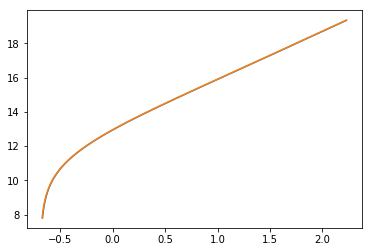

In [4453]:
zeropoint = [ [ 25.6883657251, 25.3513881707, 24.7619199882],\
             [ 25.6914396869, 25.3488107670, 24.7626744847] ]
text = [  'GaiaDR2_Passbands_ZeroPoints/GaiaDR2_Passbands.dat',\
        'GaiaDR2_Revised_Passbands_ZeroPoints/GaiaDR2_RevisedPassbands.dat']
for j in range(2):
    Table.read(text,format='ascii')
    passband['col2'][passband['col2']==99.99] = 0
    passband['col3'][passband['col3']==99.99] = 0
    passband['col4'][passband['col4']==99.99] = 0
    passband['col5'][passband['col5']==99.99] = 0
    passband['col6'][passband['col6']==99.99] = 0
    passband['col7'][passband['col7']==99.99] = 0
    lam = passband['col1']*10**(-9)
    const = 1.4387752e-2
    T = np.arange(3000,400000,1000.0)
    Gband = np.empty_like(T)
    bpband = np.empty_like(T)
    rpband = np.empty_like(T)
    flux_total = np.empty_like(T)
    # 25.6883657251   0.0017850023  25.3513881707   0.0013918258  24.7619199882   0.0019145719 
    for i in range(len(T)):
        flux = (1/passband['col1']**5/(np.exp(const/lam/T[i])-1)*lam)[1:-1]*\
        (passband['col1'][2:]-passband['col1'][:-2])
        Gband[i] = -2.5*np.log10((flux*passband['col2'][1:-1]).sum())+zeropoint[j][0]
        bpband[i] = -2.5*np.log10((flux*passband['col4'][1:-1]).sum()/\
                                  (flux*passband['col6'][1:-1]).sum())+\
                    zeropoint[j][1]-zeropoint[j][2]
        flux_total[i] = flux.sum()
    plt.plot(bpband,Gband-58,)
plt.show()

/Users/scheng/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/scheng/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


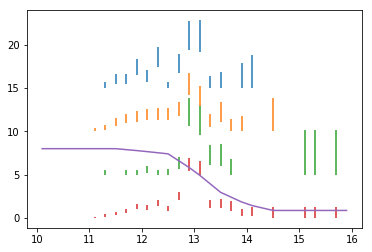

285


In [4830]:
distance = 200
dvel = [7.5,7.5,100,400]
vel = [7.5,22.5,150,50]
for i in range(len(vel)):
    selected2 = (1/WD['parallax']*1000<distance) *\
        (np.abs(WD['v']-vel[i])<dvel[i]) *\
        (WD['mass_DB_ONe']>1.05) * (WD['mass_DB_ONe']<1.15)
    count,bins = np.histogram(WD['G'][selected2],30,(10,16))
    #count,bins = np.histogram(WD['bp_rp'][selected2],30,(-0.6,1.2))
    y = count/completeness_func((bins[:-1]+bins[1:])/2)
    plt.errorbar((bins[:-1]+bins[1:])/2, y/y.mean()-i*5+5*len(vel)-5,\
                np.sqrt(count)/completeness_func((bins[:-1]+bins[1:])/2)/y.mean(),ls='none')
    #plt.plot((bins[:-1]+bins[1:])/2, count/count.mean()-i*5+5*len(vel)-5)
plt.plot((bins[:-1]+bins[1:])/2,10*completeness_func((bins[:-1]+bins[1:])/2))
plt.show()
print(selected2.sum())

## Statistical Test for the difference of Q branch of low velocity / high velocity group

In [4844]:
dvel = [7.5,7.5,100,100]
vel = [7.5,22.5,150,50]
dvel = [7.5,7.5,7.5,50]
vel = [7.5,15+7.5,30+7.5,45+50]
dvel = [25,50]
vel = [25,45+50]
for i in range(len(vel)):
    #H, X_display, Y_display = plot_vel_sample(WD,WD_model,vel[i],dvel[i],\
    #                                          'scatter',distance,pl_model_hess=False)
    selected2 = (1/WD['parallax']*1000<distance) *\
         (np.abs(WD['v']-vel[i])<dvel[i])
    #WD_HR.hess(WD['bp_rp'][selected2],WD['G'][selected2],-0.6,2.5,20,16,8,10,log=False)
    box=[-0.40,0.10,13.1,0.30,1]
    xmin = box[0]
    xmax = box[1]
    offset = box[2]
    width = box[3]
    slope = box[4]
    func = lambda x, offset, slope: offset+x*slope
    func_select = lambda x, y, offset, slope, width, xmin, xmax:\
        (np.abs(offset+x*slope-y)<width) * (x>xmin) * (x<xmax)
    #plt.plot([xmin, xmin, xmax, xmax, xmin],\
    #                 [func(xmin,offset,slope)-width,func(xmin,offset,slope)+width,\
    #                  func(xmax,offset,slope)+width,func(xmax,offset,slope)-width,\
    #                  func(xmin,offset,slope)-width ])
    high_mass = (WD['age_DA_thick_ONe']>0.15)*(WD['age_DA_thick_ONe']<2)*\
                    (WD['mass_DA_thick_ONe']>0.9)
    Q_branch = func_select(WD['bp_rp'],WD['G'],13.1,1.3,0.25,-0.50,0.10)*high_mass
    print((Q_branch*selected2).sum()/(high_mass*selected2).sum(),\
          (Q_branch*selected2).sum(), (high_mass*selected2).sum(),
         )

0.268421052632 357 1330
0.526041666667 101 192


/Users/scheng/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/scheng/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


In [4841]:
importlib.reload(WD_HR)

<module 'WD_HR' from '/Users/scheng/Gaia/WD_HR.py'>

In [4869]:
def plot_hist(WD_sdss,v,vm=0,vM=200):
    plt.figure(figsize=(12,6))
    plt.subplot(2,3,1)
    amB = (WD_sdss['age_DA_thick_ONe']>0.15)*(WD_sdss['age_DA_thick_ONe']<2) *\
            (WD_sdss['mass_DA_thick_ONe']>0.9)
    spec_list = ['ismag','DZ','DQ','DC','DB','DA']
    for i in range(6):
        plt.subplot(2,3,i+1)
        selected2 = WD_HR.select_type(WD_sdss,spec_list[i])*amB
        plt.hist(WD_sdss[selected2][v],20,(vm,vM));
        plt.title(spec_list[i]+' '+str(selected2.sum()));
        plt.grid()

/Users/scheng/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/scheng/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/Users/scheng/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


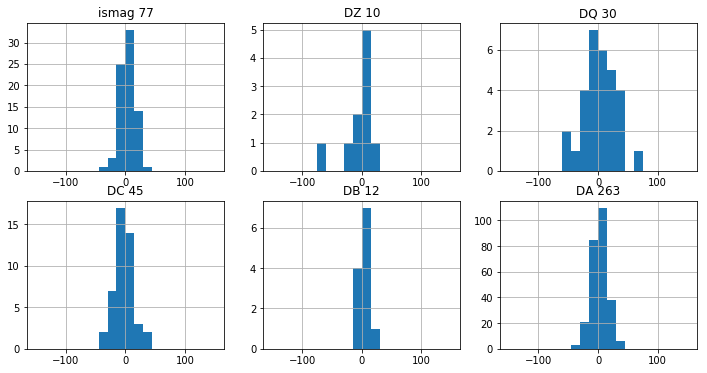

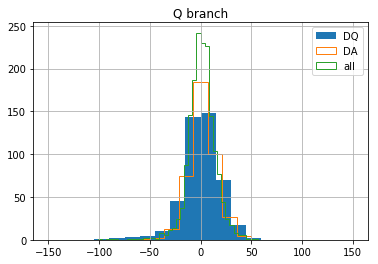

In [4922]:
v = 'W'
vm = -150
vM = 150
n = 20

plot_hist(WD_sdss[(1/WD_sdss['parallax']*1000<1000)*selected_MWDD_more],v,vm,vM)
plt.figure()
Q_branch = WD_HR.func_select(WD['bp_rp'],WD['G'],13.1,1.3,0.25,-0.50,0.10)
plt.hist(WD[Q_branch][v],20,(vm,vM),label='DQ'); 

selected2 = WD_HR.select_type(WD_sdss,'DA')*\
            (WD_sdss['age_DA_thick_ONe']>0.15)*(WD_sdss['age_DA_thick_ONe']<2) *\
            (WD_sdss['mass_DA_thick_ONe']>0.9)
plt.hist(WD_sdss[selected2][v],int(n*Q_branch.sum()/selected2.sum()),(vm,vM),\
            label='DA',histtype='step')

selected2 = (WD['age_DA_thick_ONe']>0.15)*(WD['age_DA_thick_ONe']<2) *\
            (WD['mass_DA_thick_ONe']>0.9)
plt.hist(WD[selected2][v],int(n/Q_branch.sum()*selected2.sum()),(vm,vM),\
            label='all',histtype='step')

plt.title('Q branch'); plt.grid();plt.legend()
plt.show()

/Users/scheng/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)


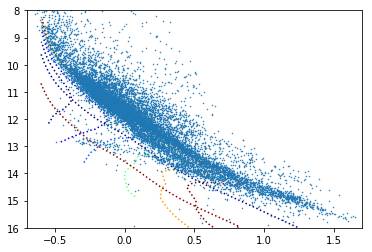

/Users/scheng/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/scheng/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


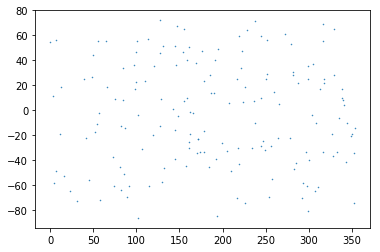

In [4894]:
vlim = 50
c1 = eval('(WD[\'v\']>vlim)')
plt.plot(WD['bp_rp'][c1],\
         WD['G'][c1],'.',ms=1)
#plt.plot(WD['bp_rp'][Q_branch*c1],
#         WD['G'][Q_branch*c1],'.',ms=1)

WD_models.plot_contours(\
10**(WD_model['grid_logage']-9),[0.15,0.5,1,2,3,4],[],0,stars='off',linestyle='dotted')
WD_models.plot_contours(\
    WD_model['grid_mass'],[0.9,1.15],[],0,stars='off',linestyle='dotted')

plt.xlim(-0.7,1.7)
plt.ylim(16,8)
plt.show()


selected2 = (WD['age_DA_thick_ONe']>0.15)*(WD['age_DA_thick_ONe']<2) *\
            (WD['mass_DA_thick_ONe']>0.9)
#plt.plot(WD['l'][c1],\
#         WD['b'][c1],'.',ms=1)
plt.plot(WD['l'][selected2*c1],
         WD['b'][selected2*c1],'.',ms=1)
plt.show()

## select again

In [4818]:
importlib.reload(WD_HR)
WD_warwick['v'], WD_warwick['ev'], WD_warwick['U'], WD_warwick['V'], WD_warwick['W']=\
        WD_HR.get_v_and_ev(WD_warwick)
WD_sdss['v'], WD_sdss['ev'], WD_sdss['U'], WD_sdss['V'], WD_sdss['W'] = WD_HR.get_v_and_ev(WD_sdss)

selected = select_WD(WD_warwick,1.3,bprp_error=0.1,ev=1,G=19,d_ed=8)
selected_MWDD = select_WD(WD_sdss,1.3,0.10,1.0,22,8)
WD = WD_warwick[selected].copy()

for spec_type, model in \
    [['DA_thick','CO'],['DA_thick','ONe'],['DB','CO'],['DB','ONe']]:
    age_planet, mass_planet = para_of_WD(WD_sdss) 
    WD_sdss['age_'+spec_type+'_'+model] = age_planet
    WD_sdss['mass_'+spec_type+'_'+model] = mass_planet

for spec_type, model in \
    [['DA_thick','CO'],['DA_thick','ONe'],['DB','CO'],['DB','ONe']]:
    age_planet, mass_planet = para_of_WD(WD) 
    WD['age_'+spec_type+'_'+model] = age_planet
    WD['mass_'+spec_type+'_'+model] = mass_planet

53872
8779


/Users/scheng/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/Users/scheng/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Warning: converting a masked element to nan.


122
61
28


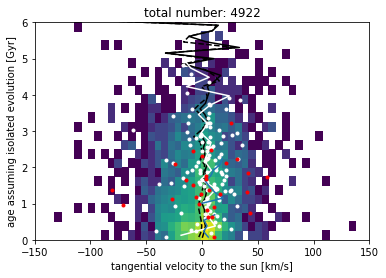

In [4927]:
def age_v(WD,WD_sdss):
    v = 'U'
    xm = -150; xM = 150
    selected2 = (WD['mass_DB_CO']>0.75)*(1/WD['parallax']*1000<1000)
    x_hess = (WD[v])[selected2]
    x = eval('(WD_sdss[\''+v+'\'])')
    
    y_hess = WD['age_DA_thick_CO'][selected2]
    hess(x_hess,y_hess,xm,xM,50,0,10,40)
    plt.title('total number: '+str(selected2.sum()));
    running_median_x(x_hess,y_hess,xm,xM,50,0,6,40,fmt='-k')
    running_median_x(x_hess,y_hess,xm,xM,50,0,6,40,fmt='--k',method='mean')
    
    #non DA
    selected2 = (WD_sdss['mass_DB_CO']>0.8) * \
            ( (WD_sdss['spectype']=='DZ')|(WD_sdss['spectype']=='DC')|\
             (WD_sdss['spectype']=='DAZ')|(WD_sdss['spectype']=='DZA')|\
            (WD_sdss['spectype']=='DB')|(WD_sdss['spectype']=='DBA'))
    print(selected2.sum())
    running_median_x(x[selected2],WD_sdss['age_DB_CO'][selected2],\
                     0,xM,50,0,10,40,fmt='-w',method='median')
    plt.plot(x[selected2],WD_sdss['age_DB_CO'][selected2],'.w')
    
    #DA
    selected2 = ((WD_sdss['ismag_more']==True)+(WD_sdss['ismag'].mask==False))*\
             (WD_sdss['mass_DA_thick_CO']>0.8) *\
            ( (WD_sdss['spectype']=='DA') )
    print(selected2.sum())
    running_median_x(x[selected2],WD_sdss['age_DA_thick_CO'][selected2],xm,xM,50,0,6,40,fmt='-',method='median')

    #DQ
    selected2 = (WD_sdss['mass_DB_CO']>0.8) * \
            ( (WD_sdss['spectype']=='DQ')|(WD_sdss['spectype']=='DQ_CI')|\
             (WD_sdss['spectype']=='DQ_CII') | (WD_sdss['spectype']=='DQ:'))
    print(selected2.sum())
    #running_median_x(x[selected2],WD_sdss['age_DB_CO'][selected2],\
    #                 xm,xM,50,0,6,40,fmt='--r',method='mean')
    plt.plot(x[selected2],WD_sdss['age_DB_CO'][selected2],'.r')
    
    plt.xlim(xm,xM); plt.ylim(0,6)
    plt.xlabel('tangential velocity to the sun [km/s]'); plt.ylabel('age assuming isolated evolution [Gyr]')
    plt.show()

age_v(WD,WD_sdss[selected_MWDD])

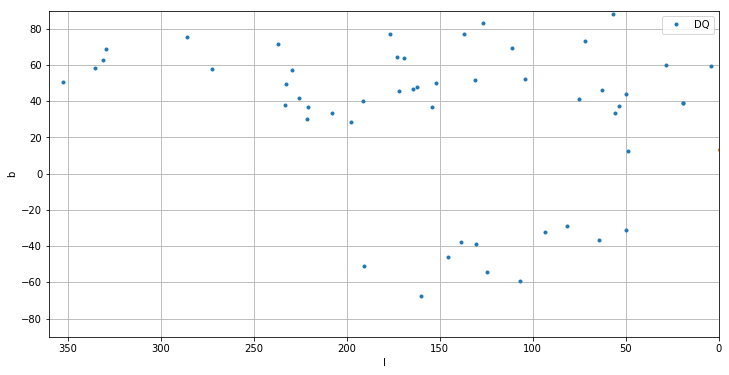

In [3592]:
distance = 100
plt_list = ['DA','DB','DC','DQ','DZ','mag']
plt_list = ['DQ']
selected2 = selected_MWDD * (1/WD_sdss['parallax']*1000<distance) *\
     (WD_sdss['MWDD_d']<10)
_ = WD_HR.plot_HR(WD_sdss[selected2],plt_list,plot_type='lb')
plt.show()

421
2858


/Users/scheng/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/Users/scheng/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


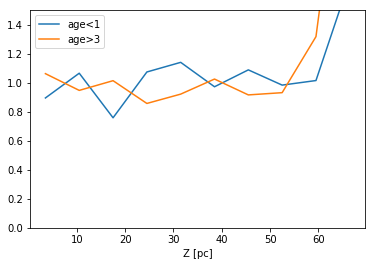

1548


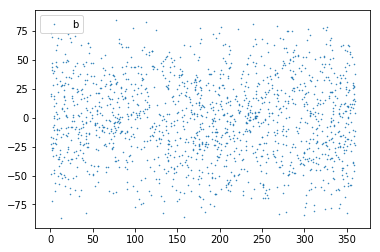

In [4895]:
distance = 70
v = WD['v']
age = WD['age_DA_thick_ONe']
for criterion in ['age<1','age>3']:
#for criterion in ['v<25.6','v>50']:
    selected2 = (1/WD['parallax']*1000<distance) * eval(criterion)
    print(selected2.sum())
    #plt.plot(WD['l'][selected2],WD['b'][selected2],'.',ms=1,alpha=1)
    #plt.scatter(WD['l'][selected2],WD['b'][selected2],c=1/WD['parallax'][selected2]*1000,\
    #            s=1,alpha=1)
    #hess_median(WD['l'][selected2],WD['b'][selected2],1/WD['parallax'][selected2]*1000,\
    #           0,360,18,-90,90,9)
    count,bins = np.histogram(np.abs(1/WD['parallax']*np.sin(WD['b']/180*np.pi)-0.020)[selected2]*1000,\
                        10,(0,distance))
    y = count/(bins[1:]-bins[:-1]-(bins[1:]**3-bins[:-1]**3)/3/distance**2)
    plt.plot((bins[1:]+bins[:-1])/2, \
             y/y[:-1].mean(),\
             label=criterion)
plt.xlabel('Z [pc]')
plt.ylim(0,1.5)
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
for criterion in ['v<25']:
    selected2 = (1/WD['parallax']*1000<distance) * eval(criterion)
    print(selected2.sum())
    plt.plot(WD['l'][selected2],WD['b'][selected2],'.',ms=1,alpha=1)
    
#selected2 = (1/WD_sdss['parallax']*1000<distance) * (WD_sdss['v']<25.6)
#print(selected2.sum())
#plt.plot(WD_sdss['l'][selected2],WD_sdss['b'][selected2],'.',ms=1,alpha=1)
        
plt.legend()
plt.show()

/Users/scheng/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


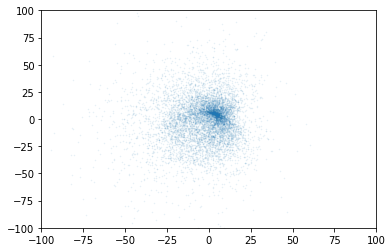

In [4682]:
Z = np.sin(WD['b']/180*np.pi)/WD['parallax']
X = np.cos(WD['l']/180*np.pi)*np.cos(WD['b']/180*np.pi)/WD['parallax']
Y = np.sin(WD['l']/180*np.pi)*np.cos(WD['b']/180*np.pi)/WD['parallax']
U = WD['U']
V = WD['V']
selected2 = WD['age_DA_thick_CO']<1
plt.plot(V[selected2],U[selected2],'.',ms=1,alpha=0.1)
#plt.xlim(0.5,-0.5);plt.ylim(0.5,-0.5)
plt.xlim(-100,100);plt.ylim(-100,100)
plt.show()

/Users/scheng/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Warning: converting a masked element to nan.
  app.launch_new_instance()
/Users/scheng/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)


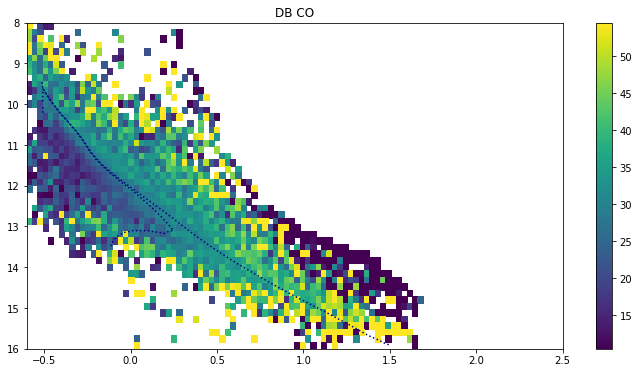

In [4650]:
dvel = [300]
vel = [150]
for i in range(len(vel)):
    H, X_display, Y_display = plot_vel_sample(WD,WD_model,vel[i],dvel[i],'hess_median',300)
    H_ensemble.append(H)
plt.show()

/Users/scheng/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Warning: converting a masked element to nan.
  app.launch_new_instance()
/Users/scheng/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)


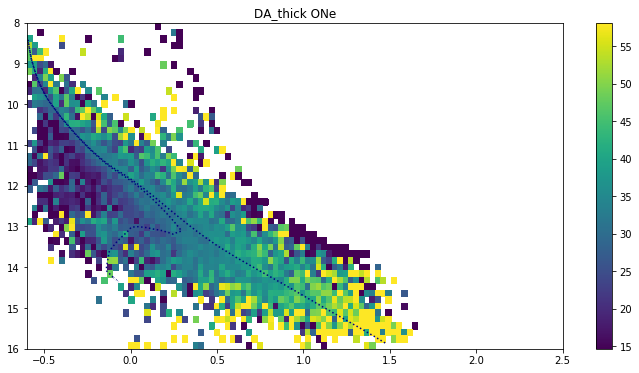

In [3033]:
dvel = [300]
vel = [150]
for i in range(len(vel)):
    H, X_display, Y_display = plot_vel_sample(vel[i],dvel[i],'hess_median',200)
    H_ensemble.append(H)
plt.show()

/Users/scheng/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Warning: converting a masked element to nan.
  app.launch_new_instance()
/Users/scheng/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)


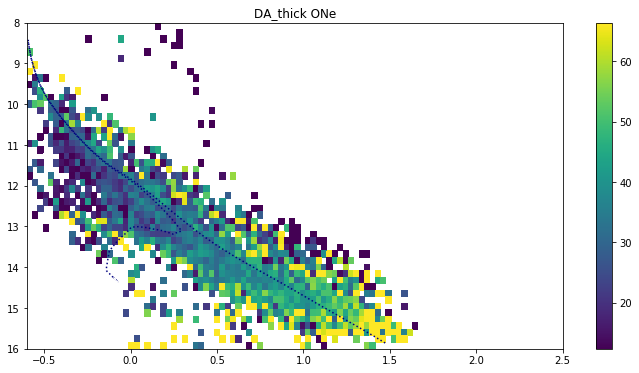

In [3034]:
#dvel = [7,10,10,10,70]
#vel = [13,30,50,70,130]
dvel = [300]
vel = [150]
for i in range(len(vel)):
    H, X_display, Y_display = plot_vel_sample(vel[i],dvel[i],'hess_median',100)
    H_ensemble.append(H)
plt.show()

/Users/scheng/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Warning: converting a masked element to nan.
  app.launch_new_instance()
/Users/scheng/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)


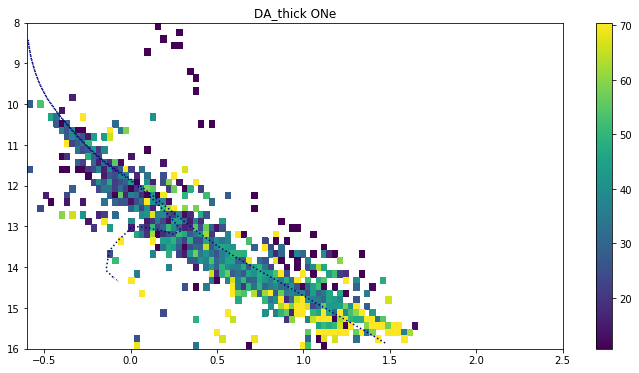

In [3035]:
dvel = [300]
vel = [150]
for i in range(len(vel)):
    H, X_display, Y_display = plot_vel_sample(vel[i],dvel[i],'hess_median',50)
    H_ensemble.append(H)
plt.show()

/Users/scheng/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/scheng/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:5144: RuntimeWarning: Mean of empty slice.
  dtype=dtype, **kwargs)[()]
/Users/scheng/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


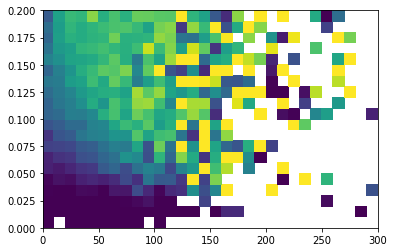

In [3523]:
x = (WD['pmra']**2 + WD['pmdec']**2)**0.5/1000 * (1/WD['parallax']*1000) \
                                                        *1.5*10**8/3600/24/365.24
y = 1/WD['parallax']                                        
z = ((WD['phot_bp_mean_flux_error']/WD['phot_bp_mean_flux'])**2+\
        (WD['phot_bp_mean_flux_error']/WD['phot_bp_mean_flux'])**2)**0.5
hess_median(x,y,z,0,300,30,0,0.2,20)
#plt.scatter(x,y,c=z,s=1,alpha=0.1)
plt.ylim(0,0.2)
plt.xlim(0,300)
plt.show()

/Users/scheng/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Warning: converting a masked element to nan.
  app.launch_new_instance()


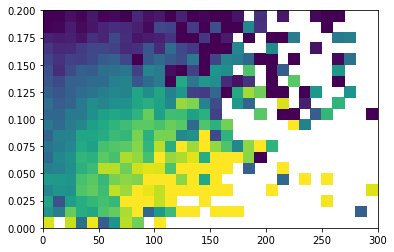

In [3042]:

x = (WD['pmra']**2 + WD['pmdec']**2)**0.5/1000 * (1/WD['parallax']*1000) \
                                                        *1.5*10**8/3600/24/365.24
y = 1/WD['parallax']
z = WD['G']
hess_median(x,y,z,0,300,30,0,0.2,20)
#plt.scatter(x,y,c=z,s=1,alpha=0.1)
plt.ylim(0,0.2)
plt.xlim(0,300)
plt.show()

/Users/scheng/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Warning: converting a masked element to nan.
  app.launch_new_instance()


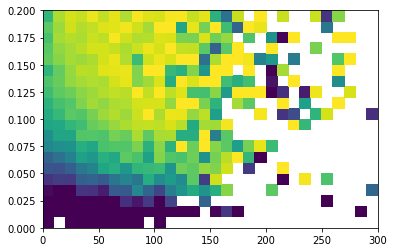

In [3519]:
x = (WD['pmra']**2 + WD['pmdec']**2)**0.5/1000 * (1/WD['parallax']*1000) \
                                                        *1.5*10**8/3600/24/365.24
y = 1/WD['parallax']
z = WD['phot_g_mean_mag']
hess_median(x,y,z,0,300,30,0,0.2,20)
#plt.scatter(x,y,c=z,s=1,alpha=0.1)
plt.ylim(0,0.2)
plt.xlim(0,300)
plt.show()

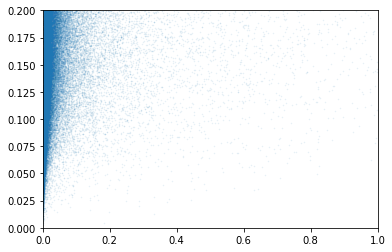

In [2708]:
z = np.abs(WD['pmdec_error']/WD['pmdec'])
plt.plot(z,1/WD['parallax'],'.',ms=1,alpha=0.1)
plt.xlim(0,1)
plt.ylim(0,0.2)
plt.show()

In [2410]:
age = 10**WD_models.grid_logage_func(WD['bp_rp'][selected2],WD['G'][selected2])/10**9
mass = WD_models.grid_mass_func(WD['bp_rp'][selected2],WD['G'][selected2])

/Users/scheng/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:973: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


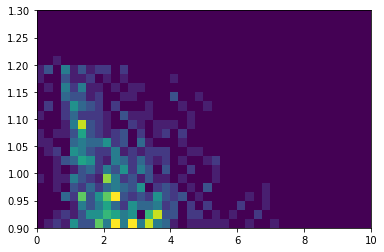

In [2442]:
def hess(x,y,res1,res2,xm, xM, ym, yM):
    H, xedges, yedges = np.histogram2d(x, y, bins=(res1,res2),\
                                   range=((min(xm,xM),max(xm,xM)),\
                                          (min(ym,yM),max(ym,yM))))
    H = H.T
    X_display, Y_display = np.meshgrid(xedges, yedges)
    plt.pcolormesh(X_display, Y_display, H)
    return None
hess(age,mass,40,24,0,10,0.9,1.3)
plt.show()

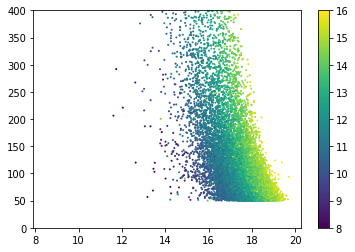

In [1850]:
x = WD['phot_g_mean_mag']
y = WD['parallax']/WD['parallax_error']
#y = WD['astrometric_excess_noise']
z = WD['G']#1/WD['parallax']*1000
plt.scatter(x,y,c=z,s=1,vmin=8,vmax=16,alpha=1)
plt.ylim(0,400)
plt.colorbar()
plt.show()

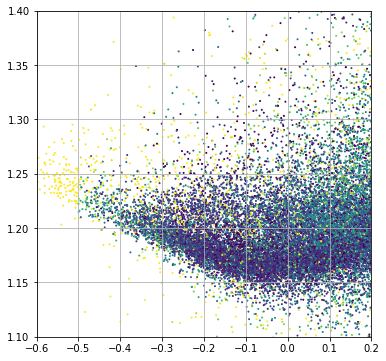

In [1791]:
selected = (WD_warwick['phot_bp_rp_excess_factor']<1.40)*\
            (WD_warwick['parallax']/WD_warwick['parallax_error']>5) *\
            (1/WD_warwick['parallax']<0.20) *\
        (np.sqrt(WD_warwick['phot_bp_mean_flux_error']/WD_warwick['phot_bp_mean_flux'])**2+\
        (WD_warwick['phot_bp_mean_flux_error']/WD_warwick['phot_bp_mean_flux'])**2 <0.1 ) *\
        (WD_warwick['Pwd']>0.9) *\
        (WD_warwick['astrometric_excess_noise'])
WD = WD_warwick[selected]
plt.figure(figsize=(6,6))
x = WD['bp_rp']
G = WD['phot_g_mean_mag']+5*np.log10(WD['parallax']/1000)+5
selected = (x<15000)# * (y>8) * (x>-0.6)
y = WD['phot_bp_rp_excess_factor']
mass = WD['phot_g_mean_mag']+5*np.log10(WD['parallax']/1000)+5-DA_G_bprp_func(np.array(x))
#y = WD['astrometric_excess_noise']
plt.scatter(x[selected],y[selected],c=mass[selected],s=1,vmin=0,vmax=2)
plt.xlim(-0.6,0.2)
plt.ylim(1.1,1.4)
#plt.ylim(0,2)
plt.grid()
plt.show()

In [ ]:
age = 10**WD_models.grid_logage_func(WD['bp_rp'][selected2],WD['G'][selected2])/10**9
mass = WD_models.grid_mass_func(WD['bp_rp'][selected2],WD['G'][selected2])

## Generate the Basic Table for Planet Project

In [2961]:
def get_WD_planet(WD_table):
    selected = (WD_table['phot_bp_rp_excess_factor']<1.40) *\
    (WD_table['parallax']/WD_table['parallax_error']>7) *\
        ( ((WD_table['phot_bp_mean_flux_error']/WD_table['phot_bp_mean_flux'])**2+\
        (WD_table['phot_bp_mean_flux_error']/WD_table['phot_bp_mean_flux'])**2)**0.5 <0.1) *\
               (WD_table['bp_rp']<0.2) * (WD_table['bp_rp']>-0.7) *\
                (WD_table['G']<15) * (WD_table['G']-WD_table['bp_rp']*5>10) *\
                (1/WD_table['parallax']*1000<100)
    print(selected.sum())
    return WD_table[selected].copy()

WD_planet = get_WD_planet(WD_warwick)
np.save('MassiveYoungWDandPlanet/WD_planet.npy',np.array([{'WD_planet':WD_planet}]))

2800
